<a href="https://colab.research.google.com/github/Naoki0424/my_document/blob/main/20211027_orenist_convolution_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 畳み込みフィルターの適用をやってみよう

## ライブラリインポート

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import tensorflow as tf
from  tensorflow.keras import layers, models

In [25]:
!curl -LO https://github.com/enakai00/colab_tfbook/raw/master/Chapter04/ORENIST.data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   151  100   151    0     0    511      0 --:--:-- --:--:-- --:--:--   511
100  553k  100  553k    0     0  1044k      0 --:--:-- --:--:-- --:--:-- 1044k


縦横のエッジが見えやすい独自データのダウンロードを行います。

In [26]:
with open('ORENIST.data', 'rb')as file:
  images, labels = pickle.load(file)

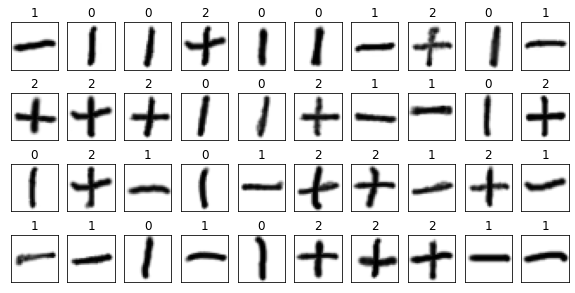

In [27]:
fig = plt.figure(figsize=(10, 5))
for i in range(40):
  subplot = fig.add_subplot(4, 10, i+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.set_title('%d' % np.argmax(labels[i]))
  subplot.imshow(images[i].reshape(28, 28), vmin=0, vmax=1, cmap=plt.cm.gray_r)

ダウンロードしたデータのサンプルです

## フィルターを用意する

In [28]:
def edge_filter(shape=None, dtype=None):
  filter0 = np.array(
      [[2, 1, 0, -1, -2],
       [3, 2, 0, -2, -3],
       [4, 3, 0, -3, -4],
       [3, 2, 0, -2, -3],
       [2, 1, 0, -1, -2]] 
  ) / 23.0

  filter1 = np.array(
      [[2, 3, 4, 3, 2],
       [1, 2, 3, 2, 1],
       [0, 0, 0, 0, 0],
       [-1, -2, -3, -2, -1],
       [-2, -3, -4, -3, -2]] 
  ) / 23.0

  filter_array = np.zeros([5, 5, 1, 2])
  filter_array[:, :, 0, 0] = filter0
  filter_array[:, :, 0, 1] = filter1

  return filter_array

2次元リストとして、`filter0`、`filter1`を定義した後に5 * 5 * 1 * 2サイズのarrayオブジェクトに格納しています。

## モデルの定義

In [29]:
model = models.Sequential()
model.add(layers.Reshape((28, 28, 1), input_shape=(28*28, ), name='reshape'))
model.add(layers.Conv2D(2, (5, 5), padding='same', kernel_initializer=edge_filter, use_bias=False, name='conv_filter'))
model.add(layers.Lambda(lambda x: abs(x), name='abs'))
model.add(layers.Lambda(lambda x: tf.keras.backend.relu(x-0.2), name='cut_off'))
model.add(layers.MaxPool2D((2, 2), name='max_pooling'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv_filter (Conv2D)         (None, 28, 28, 2)         50        
_________________________________________________________________
abs (Lambda)                 (None, 28, 28, 2)         0         
_________________________________________________________________
cut_off (Lambda)             (None, 28, 28, 2)         0         
_________________________________________________________________
max_pooling (MaxPooling2D)   (None, 14, 14, 2)         0         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________


各層の説明を行います。

第１層目：`layers.Reshape()`

ここでは入力データの形状を変更しています。元々は各ピクセル(28*28, )と言う横１列で濃度を持っていましたが、Reshapeにより縦横28*28*1に変換しています。一般的には「縦＊横＊レイヤー数」と言う形式に変換して畳み込みフィルターを適用させます。レイヤー数は色を表していて、RGBの場合は３で、今回の場合は入力画像がグレースケールのため１となっています

第２層目：`layers.Conv2D()`

ここでは畳み込みフィルターの適用を行っています。最初の２つのオプションでフィルターの数(2)とサイズ((5*5))を設定しています。`kernel_initializer`でフィルターの初期値を設定しています。`padding`オプションではフィルターをストライドさせた際に、はみ出たピクセルをどのような値で扱うか設定します。ここでは`same`としているため0として計算しています。

第３層目、４層目：`Lamda()`

ここでは指定した任意の関数の実行を行うノードを定義しています。
第３層目では絶対値を指定しています。今回の畳み込みフィルターでは、ピクセルが負の値になる可能性があります。それを強制的に正の値に変換しています。

第４層目はフィルターの効果を分かりやすくするために追加した層です。
活性化関数にReluを用いているので出力値を0とする範囲を広げています。

## ニューラルネットワークの中間部分を取り出す

kerasにはニューラルネットワークの中間部分の出力を取り出す機能があります。
それを利用しプーリング層の適用前と後の出力を個別に取り出し確認を行います。

In [30]:
# cut_offまでの計算結果とmax_poolingまでの計算結果が出力となるようなモデルを作成する
layer_outputs = [model.get_layer('cut_off').output, model.get_layer('max_pooling').output]
model2 = models.Model(inputs=model.input, outputs=layer_outputs)

In [31]:
model.input.shape

TensorShape([None, 784])

In [32]:
layer_outputs

[<KerasTensor: shape=(None, 28, 28, 2) dtype=float32 (created by layer 'cut_off')>,
 <KerasTensor: shape=(None, 14, 14, 2) dtype=float32 (created by layer 'max_pooling')>]

`model.get_layer()`によりプーリング層を適用する前のレイヤーとプーリング層を適用するレイヤーを取得しています。

2行目でmodel2を作成していますが、入力部分と出力部分を明示的に設定しています。
この指定により先程のモデル(model)から特定のレイヤーの出力が可能になります。

In [33]:
conv_output, pool_output = model2.predict(np.array(images[:9]))

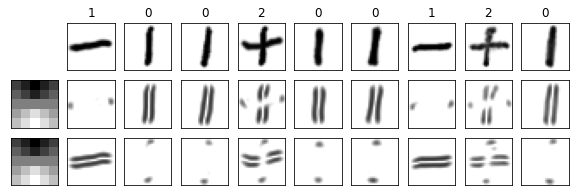

In [34]:
fig = plt.figure(figsize=(10, 3))
filter_vals = edge_filter()
v_max = np.max(conv_output)

for i in range(2):
  subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(filter_vals[:, :, 0, 1], cmap=plt.cm.gray_r)


for i in range(9):
  subplot = fig.add_subplot(3, 10, i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.set_title('%d' % np.argmax(labels[i]))
  subplot.imshow(images[i].reshape(28, 28), vmin=0, vmax=1, cmap=plt.cm.gray_r)

  subplot = fig.add_subplot(3, 10, 10+i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(conv_output[i, :, :, 0], vmin=0, vmax=1, cmap=plt.cm.gray_r)

  subplot = fig.add_subplot(3, 10, 20+i+2)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(conv_output[i, :, :, 1], vmin=0, vmax=1, cmap=plt.cm.gray_r)